In [467]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.metrics import RootMeanSquaredError
from keras.backend import clear_session
from copy import copy


First, clean up the data set to make testing easier. Importantly, analysing data from too far in the past is not very applicable to today's markets, e.g. NYA in the 1960's. Further, some stock exchanges do not have data that far in the past, either due to lack of data or the exchange not existing. Thus to allow for cross comparison of exchanges we will normalise the data sets such that they all start in the 2000's.

In [2]:
df = pd.read_csv("indexProcessed.csv")
var = "2005-01-01"
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.strftime('%Y-%m-%d')) >= var]
null_volume = 0
df.query("Volume != @null_volume", inplace=True)

Split the main data set into sub sets for each exchange.

In [3]:
# list of all indexes
index_list = []

# create folder for splitting the original csv 
if not os.path.exists("data_by_index"): os.makedirs("data_by_index")
# split the original csv into index only
for (index), group in df.groupby('Index'):
     group.to_csv(f'data_by_index/{index}.csv', index=False)
     index_list.append({index})

# example csv split
pd.read_csv("data_by_index/NYA.csv").set_index("Date")

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Date,,,,,,,,
2005-01-03,NYA,7250.060059,7268.209961,7174.000000,7179.709961,7179.709961,1.505900e+09,7179.709961
2005-01-04,NYA,7179.709961,7191.240234,7084.149902,7090.520020,7090.520020,1.721000e+09,7090.520020
2005-01-05,NYA,7090.520020,7103.520020,7055.089844,7055.209961,7055.209961,1.736800e+09,7055.209961
2005-01-06,NYA,7055.220215,7095.990234,7052.819824,7076.939941,7076.939941,1.569100e+09,7076.939941
2005-01-07,NYA,7076.939941,7102.790039,7039.410156,7057.509766,7057.509766,1.477900e+09,7057.509766
...,...,...,...,...,...,...,...,...
2021-05-24,NYA,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450
2021-05-25,NYA,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450
2021-05-26,NYA,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940


Create the log return function to classify a day as positive or negative returns

In [ ]:
# Log return function
def lg_return(df):
    lg_return_list = []
    up_down = []
    for index, row in df.iterrows():
        # use lg return formula
        daily_return = (np.log(row["Close"]) - np.log(row["Open"]))
        lg_return_list.append(daily_return)
        if daily_return > 0:
            up_down.append("UP")
        else:
            up_down.append("DOWN")
    return lg_return_list, up_down

Read the NYSE and TSE data sets and insert the log returns and forecast for date

In [4]:
nya_df = pd.read_csv("data_by_index/NYA.csv").set_index("Date")
tko_df = pd.read_csv("data_by_index/N225.csv").set_index("Date")


# insert log returns to each dataset
nya_df.insert(8, "Daily Log Returns", lg_return(nya_df)[0])
nya_df.insert(9, "Overall Forecast", lg_return(nya_df)[1])
tko_df.insert(8, "Daily Log Returns", lg_return(tko_df)[0])
tko_df.insert(9, "Overall Forecast", lg_return(tko_df)[1])

Finally, we shall even out the data frames such that they have the same dates, this will make combining the dataset easier.

In [ ]:
def even_out_frames(df1, df2):
    
    df1_index = df1.index.to_numpy()
    for index, row in df2.iterrows():
        if index not in df1_index:
            df2.drop(index=index, inplace=True)
    
    df2_index = df2.index.to_numpy()
    for index, row in df1.iterrows():
        if index not in df2_index:
                df1.drop(index=index, inplace=True)
    return 0

In [5]:
even_out_frames(tko_df, nya_df)
tko_df

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Daily Log Returns,Overall Forecast
Date,,,,,,,,,,
2005-01-04,N225,11458.26953,11547.01953,11431.57031,11517.75000,11517.75000,41000000.0,115.177500,0.005178,UP
2005-01-05,N225,11458.91992,11461.09961,11416.96973,11437.51953,11437.51953,77500000.0,114.375195,-0.001869,DOWN
2005-01-06,N225,11372.34961,11492.25977,11372.20996,11492.25977,11492.25977,87100000.0,114.922598,0.010489,UP
2005-01-07,N225,11528.69043,11528.69043,11432.19043,11433.24023,11433.24023,72300000.0,114.332402,-0.008314,DOWN
2005-01-11,N225,11495.45996,11580.69043,11495.45996,11539.99023,11539.99023,87800000.0,115.399902,0.003866,UP
...,...,...,...,...,...,...,...,...,...,...
2021-05-24,N225,28212.32031,28584.17969,28212.32031,28364.60938,28364.60938,54700000.0,283.646094,0.005383,UP
2021-05-25,N225,28516.99023,28576.97070,28443.74023,28553.98047,28553.98047,54000000.0,285.539805,0.001296,UP
2021-05-26,N225,28396.61914,28710.83008,28396.61914,28642.18945,28642.18945,64200000.0,286.421895,0.008611,UP


We shall now add the relevant Tokyo data to the main New York data. Note that due to the timezone difference, Tokyo's Open is the next day for NYA. Thus we have to shift the Tokyo data by one before adding it to the nya dataset.  

In [6]:
tko_close = tko_df["Close"]

nya_df.insert(10, "Prev Tokyo Close", tko_close)


tko_df.drop(index=tko_df.index[0], inplace=True)

tko_open = tko_df["Open"]

tko_open = np.append(tko_open,0)

tko_open_forecast = tko_df["Overall Forecast"]

tko_open_forecast =  np.append(tko_open_forecast,0)

nya_df.insert(11, "Next Tokyo Open", tko_open)
nya_df.insert(12, "Next Tokyo Forecast", tko_open_forecast)
nya_df.drop(index=nya_df.index[len(nya_df) - 1], inplace=True)

In [ ]:
# make folder for figures if it does not exist
if not os.path.exists("figures"): os.makedirs("figures")

<AxesSubplot: xlabel='Volume', ylabel='Next Tokyo Open'>

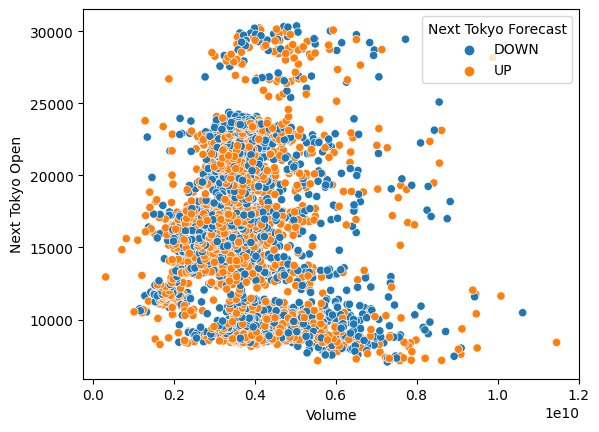

In [7]:
sns.scatterplot(data=nya_df, y="Next Tokyo Open", x="Volume", hue="Next Tokyo Forecast")
plt.savefig("figures/Vol")

<AxesSubplot: xlabel='Close', ylabel='Next Tokyo Open'>

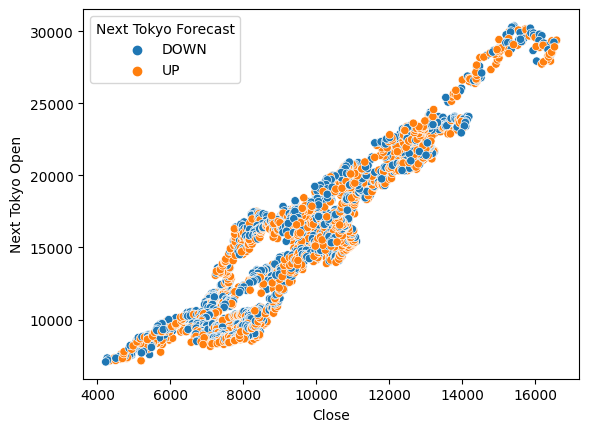

In [8]:
sns.scatterplot(data=nya_df, y="Next Tokyo Open", x="Close", hue="Next Tokyo Forecast")
plt.savefig("figures/Close")

<AxesSubplot: xlabel='Daily Log Returns', ylabel='Next Tokyo Open'>

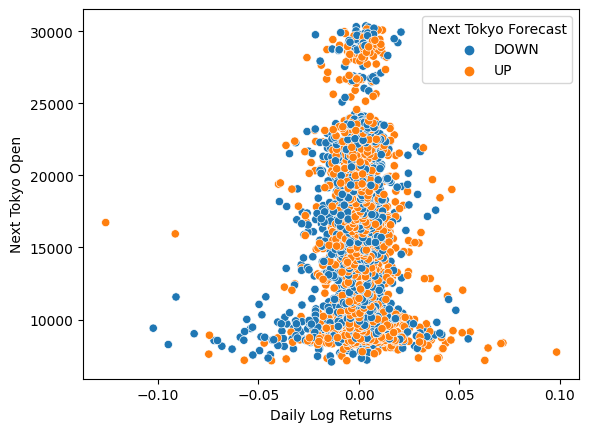

In [9]:
sns.scatterplot(data=nya_df, y="Next Tokyo Open", x="Daily Log Returns", hue="Next Tokyo Forecast")
plt.savefig("figures/LgR")

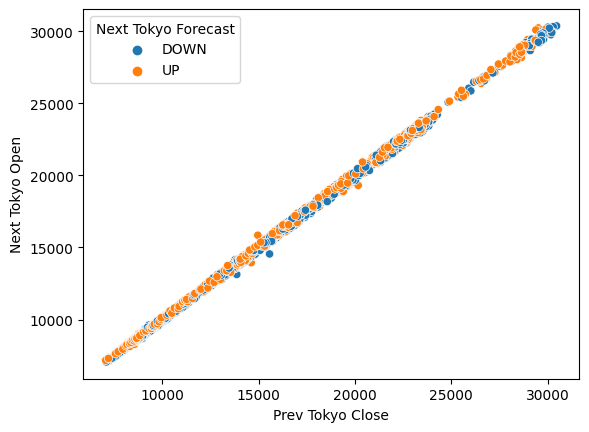

In [10]:
sns.scatterplot(data=nya_df, y="Next Tokyo Open", x="Prev Tokyo Close", hue="Next Tokyo Forecast")
plt.savefig("figures/PTC")

Finally, we remove redundant columns and scale the remaining data down to allow for more efficient training.

In [11]:
TEST_SIZE = 0.20

min_max_scaler = MinMaxScaler()

Removed_Cols = ["Index", "CloseUSD", "Adj Close", "Daily Log Returns", "Overall Forecast",  "Next Tokyo Forecast"]

scaled_data =  min_max_scaler.fit_transform(nya_df.drop(columns=Removed_Cols).values)

y_data = scaled_data[:, 6]
 
x_data = np.delete(scaled_data,  5, axis=1)

nya_train, nya_test, tko_open_train, tko_open_test = train_test_split(x_data,
                                                      y_data, 
                                                      test_size=TEST_SIZE,
                                                      shuffle=False)
                                            

# reshape training data

nya_train= np.reshape(nya_train, (nya_train.shape[0], nya_train.shape[1], 1))

scaled_data.shape

(3853, 7)

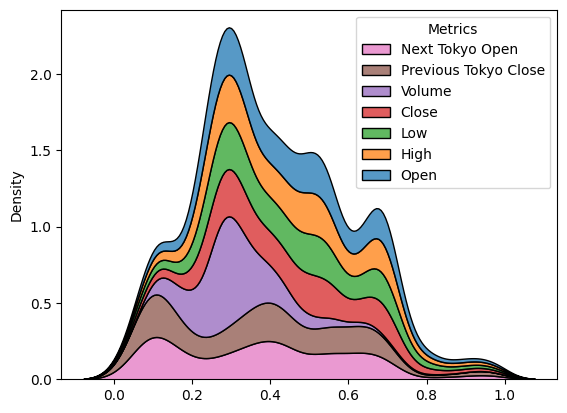

In [462]:
cols = ["Open", "High", "Low", "Close", "Volume", "Previous Tokyo Close", "Next Tokyo Open"]
cols.reverse()
sns.kdeplot(scaled_data, fill=True, multiple="stack")
plt.legend(title="Metrics", labels=cols)
plt.savefig("figures/scaled_data")

Train each model, with a maximum of 15 epochs and 10 runs using the evaluate function

In [ ]:
# lstm-gru initialisation function
def LSTM_GRU(LSTM_layer, GRU_layer,  input_shape):
    model = Sequential()
    model.add(LSTM(LSTM_layer, return_sequences=True, input_shape= input_shape))
    model.add(GRU(GRU_layer, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))
    return model

# lstm initialisation function
def LSTM_RNN(LSTM_layer, input_shape):
    model = Sequential()
    model.add(LSTM(LSTM_layer, return_sequences=False, input_shape= input_shape))
    model.add(Dense(32))
    model.add(Dense(1))
    return model

# gru initialisation function
def GRU_RNN(GRU_layer, input_shape):
    model = Sequential()
    model.add(GRU(GRU_layer, return_sequences=False, input_shape=input_shape))
    model.add(Dense(32))
    model.add(Dense(1))
    return model

# train function with respect to train, validation, model, loss and epochs
def train(x, y, x_val, y_val, model, epochs, loss):
    model.compile(optimizer='adam', loss=loss, metrics=[RootMeanSquaredError()])
    hist = model.fit(x, y, batch_size= 1, epochs=epochs, validation_data=(x_val, y_val))
    return hist

# format pd array to data frame with columns
def format_df(arr, columns):
    data = {}
    for i in range(len(columns)):
        data[columns[i]] = arr[:, i]
    return pd.DataFrame(data=data)

# reverse the min max scaler
def inverse(x,y, min_max_scaler):
    final = np.append(x, y.reshape(y.shape[0],1,1), axis=1)
    final = final.reshape(x.shape[0],x.shape[1]+1)
    final_trans = min_max_scaler.inverse_transform(final)
    return final_trans

# main evaluation function, returns evaluation criteria
def evaluate(X_train, Y_train, X_test, Y_test, rnn_type, epochs, iterations, scaler):
    predictions = [] # list of predictions
    model_history = [] # list of model history
    prediction_error = [] # list of prediction error
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    for i in range(1, iterations + 1):
        if rnn_type == "GRU":
            model = GRU_RNN(128, input_shape=(X_train.shape[1], 1))
        elif rnn_type == "LSTM":
            model = LSTM_RNN(128, input_shape=(X_train.shape[1], 1))
        else: 
            model = LSTM_GRU(64, 64, input_shape=(X_train.shape[1], 1))
        # train the data against the RMSE and validate the data against the test set. 
        hist = train(X_train, Y_train, X_test, Y_test, model, epochs, loss="mean_squared_error")
        model_history.append(hist.history)

        # predict the future data
        prediction = model.predict(X_test)

        # format the predictions into a data frame and add to the list of predictions
        prediction_df = format_df(inverse(X_test, prediction, scaler), columns=["Open", "High", "Low", "Close","Volume", "Prev Tokyo Close", "Predicted Next Tokyo Open"])
        prediction_df.insert(6, "Actual Next Tokyo Open", inverse(X_test, Y_test, scaler)[:, 6])
        predictions.append(prediction_df)
        # add the RMSE of the final epoch to the prediction error list
        prediction_error.append(mean_squared_error(Y_test, prediction, squared=False))
        # clear the model's session
        clear_session() 
        model = None 
    return predictions, model_history, prediction_error

In [12]:
MAX_EPOCH = 15

NUMBER_OF_RUNS = 10

# LSTM evaluation
predictions_lstm, model_history_lstm, prediction_error_lstm = evaluate(nya_train, tko_open_train, nya_test, tko_open_test, 
        "LSTM", MAX_EPOCH, NUMBER_OF_RUNS, min_max_scaler)

# GRU evaluation
predictions_gru, model_history_gru, prediction_error_gru = evaluate(nya_train, tko_open_train, nya_test, tko_open_test, 
        "GRU", MAX_EPOCH, NUMBER_OF_RUNS, min_max_scaler)

# LSTM-GRU evaluation
predictions_lstm_gru, model_history_lstm_gru, prediction_error_lstm_gru = evaluate(nya_train, tko_open_train, nya_test, tko_open_test, 
        "LSTM_GRU", MAX_EPOCH, NUMBER_OF_RUNS, min_max_scaler)

2022-12-06 18:44:55.301045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-06 18:44:55.301096: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 18:44:55.301132: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux-laptop): /proc/driver/nvidia/version does not exist
2022-12-06 18:44:55.301663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
3082/3082 [==============================] - 14s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 1.1500e-05 - val_root_mean_squared_error: 0.0034
Epoch 2/15
3082/3082 [==============================] - 12s 4ms/step - loss: 2.5779e-05 - root_mean_squared_error: 0.0051 - val_loss: 1.3019e-07 - val_root_mean_squared_error: 3.6082e-04
Epoch 3/15
3082/3082 [==============================] - 12s 4ms/step - loss: 6.3152e-05 - root_mean_squared_error: 0.0079 - val_loss: 6.0896e-05 - val_root_mean_squared_error: 0.0078
Epoch 4/15
3082/3082 [==============================] - 11s 4ms/step - loss: 2.2867e-05 - root_mean_squared_error: 0.0048 - val_loss: 1.6535e-06 - val_root_mean_squared_error: 0.0013
Epoch 5/15
3082/3082 [==============================] - 12s 4ms/step - loss: 2.3010e-05 - root_mean_squared_error: 0.0048 - val_loss: 2.2001e-04 - val_root_mean_squared_error: 0.0148
Epoch 6/15
3082/3082 [==============================] - 12s 4ms/step - loss: 4.3417e-

Save the predictions to CSV files

In [28]:
if not os.path.exists("gru_predictions"): os.makedirs("gru_predictions")
for i in range(len(predictions_gru)):
    predictions_gru[i].to_csv("gru_predictions/gru_prediction_" + str(i)+ "_.csv")

In [29]:
if not os.path.exists("lstm_predictions"): os.makedirs("lstm_predictions")
for i in range(len(predictions_lstm)):
    predictions_lstm[i].to_csv("lstm_predictions/lstm_prediction_" + str(i)+ "_.csv")

In [30]:
if not os.path.exists("lstm_gru_predictions"): os.makedirs("lstm_gru_predictions")
for i in range(len(predictions_lstm_gru)):
    predictions_lstm_gru[i].to_csv("lstm_gru_predictions/lstm_gru_prediction_" + str(i)+ "_.csv")

Load the predictions when evaluating at a later date

In [227]:
loaded_lstm_predictions = []

loaded_gru_predictions = []

loaded_lstm_gru_predictions = []

for csv in os.listdir(path="lstm_predictions"):
    loaded_lstm_predictions.append(pd.read_csv("lstm_predictions/" + str(csv)))

for csv in os.listdir(path="lstm_gru_predictions"):
    loaded_lstm_gru_predictions.append(pd.read_csv("lstm_gru_predictions/" + str(csv)))

for csv in os.listdir(path="gru_predictions"):
    loaded_gru_predictions.append(pd.read_csv("gru_predictions/" + str(csv)))

In [419]:
# group mode history based on epoch
def group_by_epoch(model_history, epoch):
    epoch_group = {}
    for history in model_history:
        for k in history.keys():
            if k not in epoch_group:
                epoch_group[k] = [history[k][epoch - 1]]
                continue
            epoch_group[k].append(history[k][epoch - 1])
    return epoch_group

# average function
def average(values):
    sum = 0
    for value in values:
        sum += value
    sum /= len(values)
    return sum

# average each epoch group for RMSE analysis
def analysis_by_epoch(history, max_epoch):
    history_by_epoch = []

    for i in range(1, max_epoch+1):
        history_by_epoch.append(group_by_epoch(model_history=history, epoch=i))

    average_loss_by_epoch = []

    for epoch in history_by_epoch:
        avg_epoch = {}
        for k in epoch.keys():
            avg = average(epoch[k])
            avg_epoch["average " + k] = avg
        average_loss_by_epoch.append(avg_epoch)
    
    return history_by_epoch, average_loss_by_epoch

# average all predictions for a particular model
def average_predictions(predictions):
    total = None
    for i in range(len(predictions)):
        if total is None:
            total = copy(predictions[i]["Predicted Next Tokyo Open"])
        else:
            total += predictions[i]["Predicted Next Tokyo Open"]
    # average each prediction
    total = total.apply(lambda x: x / len(predictions))
    return total


Generate model history and average

In [420]:
gru_hist, gru_avg = analysis_by_epoch(model_history_gru, MAX_EPOCH)

lstm_hist, lstm_avg = analysis_by_epoch(model_history_lstm, MAX_EPOCH)

lstm_gru_hist, lstm_gru_avg = analysis_by_epoch(model_history_lstm_gru, MAX_EPOCH)

Convert model averages to data frames, and add to a large "all errors data frame"

In [421]:
gru_avg = pd.DataFrame(gru_avg)
gru_avg = gru_avg.add_prefix("gru_")

lstm_avg = pd.DataFrame(lstm_avg)
lstm_avg= lstm_avg.add_prefix("lstm_")

lstm_gru_avg = pd.DataFrame(lstm_gru_avg)
lstm_gru_avg= lstm_gru_avg.add_prefix("lstm_gru_")

all_model_errors = pd.concat([gru_avg, lstm_avg, lstm_gru_avg], axis=1)

all_model_errors.index += 1

all_model_errors.index.rename(name="epoch", inplace=True)

In [422]:
all_model_errors

,gru_average loss,gru_average root_mean_squared_error,gru_average val_loss,gru_average val_root_mean_squared_error,lstm_average loss,lstm_average root_mean_squared_error,lstm_average val_loss,lstm_average val_root_mean_squared_error,lstm_gru_average loss,lstm_gru_average root_mean_squared_error,lstm_gru_average val_loss,lstm_gru_average val_root_mean_squared_error
epoch,,,,,,,,,,,,
1,0.000573,0.023857,0.000008,0.002446,0.001245,0.035178,0.000024,0.004326,0.002208,0.046867,0.000051,0.005797
2,0.000054,0.007333,0.000062,0.005542,0.000028,0.005270,0.000007,0.002153,0.000078,0.008814,0.000171,0.010486
3,0.000048,0.006909,0.000083,0.006937,0.000039,0.006188,0.000042,0.005054,0.000068,0.008161,0.000163,0.007601
4,0.000038,0.006137,0.000280,0.010820,0.000035,0.005845,0.000038,0.004188,0.000049,0.006918,0.000059,0.006572
5,0.000033,0.005685,0.000015,0.003245,0.000026,0.005112,0.000035,0.003993,0.000048,0.006882,0.000157,0.009374
6,0.000028,0.005251,0.000011,0.003075,0.000027,0.005196,0.000043,0.004526,0.000040,0.006322,0.000595,0.014296
7,0.000022,0.004687,0.000008,0.002597,0.000019,0.004306,0.000017,0.003205,0.000039,0.006205,0.000105,0.008853
8,0.000018,0.004283,0.000122,0.007520,0.000017,0.004148,0.000012,0.002912,0.000035,0.005904,0.000132,0.010017
9,0.000018,0.004270,0.000007,0.002428,0.000017,0.004161,0.000017,0.002640,0.000030,0.005457,0.000089,0.008957


Save all model error values to csv

In [423]:
all_model_errors.to_csv("all_model_error_vals.csv")

Create RMSE data frames with respect to the validation and training set

In [424]:
rmse_string = "_average root_mean_squared_error"

val_rmse_string = "_average val_root_mean_squared_error"

all_rmse = pd.concat([all_model_errors["lstm" + rmse_string], all_model_errors["gru" + rmse_string], all_model_errors["lstm_gru" + rmse_string]], axis=1)

all_rmse_val =  pd.concat([all_model_errors["lstm" + val_rmse_string], all_model_errors["gru" + val_rmse_string], all_model_errors["lstm_gru" + val_rmse_string]], axis=1)

In [425]:
all_rmse = all_rmse.rename(columns={"lstm_average root_mean_squared_error" : "LSTM", 
                            "gru_average root_mean_squared_error" : "GRU", 
                            "lstm_gru_average root_mean_squared_error": "LSTM-GRU"})
all_rmse_val = all_rmse_val.rename(columns={"lstm_average val_root_mean_squared_error" : "LSTM", 
                            "gru_average val_root_mean_squared_error" : "GRU", 
                            "lstm_gru_average val_root_mean_squared_error": "LSTM-GRU"})

Plot the validation score for all models

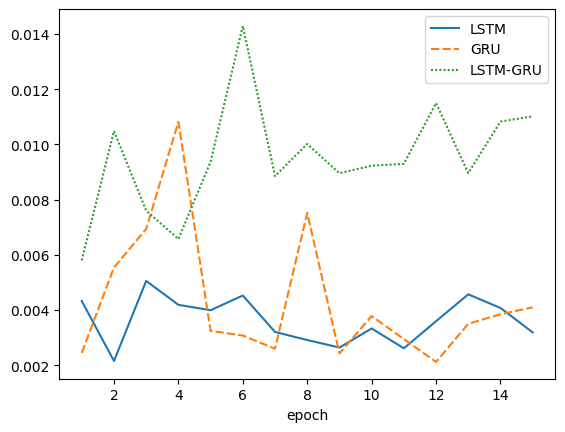

In [428]:
ax = sns.lineplot(all_rmse_val, legend=True)
plt.savefig("figures/RMSE_val")

Plot the training RMSE for all models

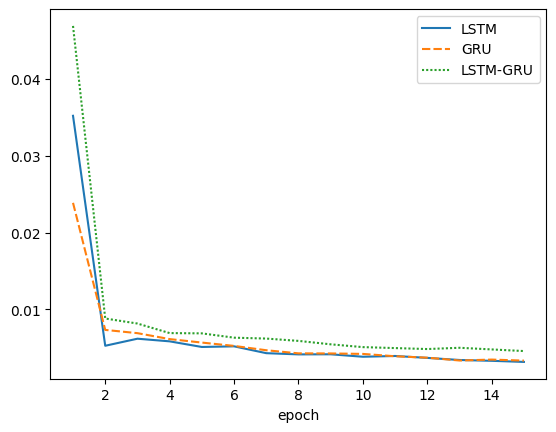

In [427]:
sns.lineplot(all_rmse)
plt.savefig("figures/RMSE")

Create average predictions for each model

In [233]:
true_vals = loaded_lstm_predictions[0]["Actual Next Tokyo Open"]

overall_predictive_average_lstm = average_predictions(loaded_lstm_predictions)
overall_predictive_average_gru = average_predictions(loaded_gru_predictions)
overall_predictive_average_lstm_gru = average_predictions(loaded_lstm_gru_predictions)

Calculate the L1-Norm for each model's prediction

In [252]:
abs_lstm_diff = abs(overall_predictive_average_lstm - true_vals)
abs_gru_diff = abs(overall_predictive_average_gru - true_vals)
abs_lstm_gru_diff = abs(overall_predictive_average_lstm_gru - true_vals)

Create the L1-Norm cumulative table 

In [434]:
abs_diff_data = {"LSTM": [], "GRU": [], "LSTM-GRU": []}

for i in [5, 25, 50, 100, 150, 200, 300, 800]:
    abs_diff_data["LSTM"].append(abs_lstm_diff[abs_lstm_diff < i].count()) 
    abs_diff_data["GRU"].append(abs_gru_diff[abs_gru_diff < i].count())
    abs_diff_data["LSTM-GRU"].append(abs_lstm_gru_diff[abs_lstm_gru_diff < i].count())

abs_diff_table = pd.DataFrame(data= abs_diff_data)

# abs_diff_table = abs_diff_table.index.rename("Predictions Greater Than")

abs_diff_table.index = ([5, 25, 50, 100, 150, 200, 300, 800])

abs_diff_table.index.name = "# of Predictions Less Than"

print(abs_diff_table["LSTM-GRU"])

# of Predictions Less Than
5       63
25     248
50     444
100    619
150    647
200    655
300    680
800    771
Name: LSTM-GRU, dtype: int64


Plot the LSTM L1-Norm values

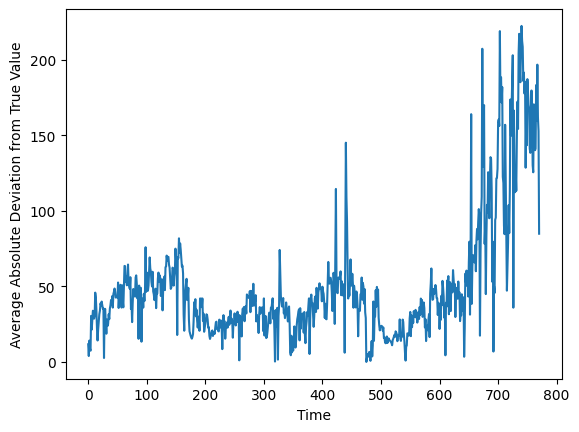

In [364]:
ax = sns.lineplot(abs_lstm_diff)
ax.set(xlabel="Time", ylabel="Average Absolute Deviation from True Value")
plt.savefig("figures/abs_lstm_diff_by_time")

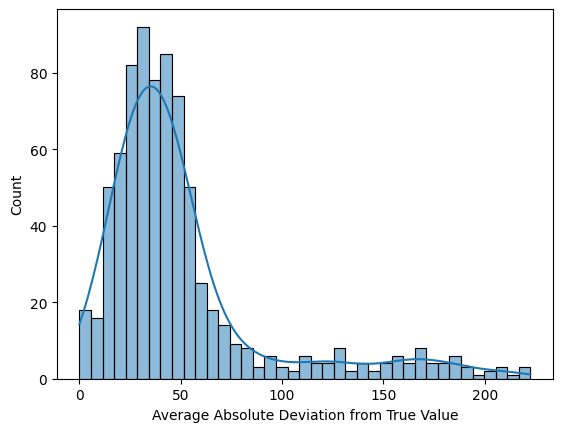

In [464]:
ax= sns.histplot(abs_lstm_diff, kde=True)
ax.set(xlabel="Average Absolute Deviation from True Value")
plt.savefig("figures/abs_dev_lstm")

GRU L1-Norm Values

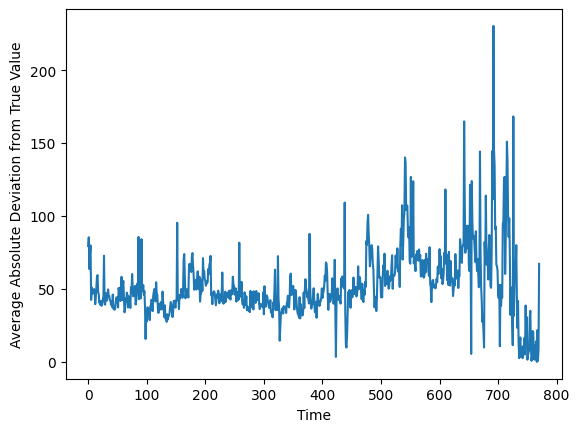

In [365]:
ax= sns.lineplot(abs_gru_diff)
ax.set(xlabel="Time", ylabel="Average Absolute Deviation from True Value")
plt.savefig("figures/abs_gru_diff_by_time")

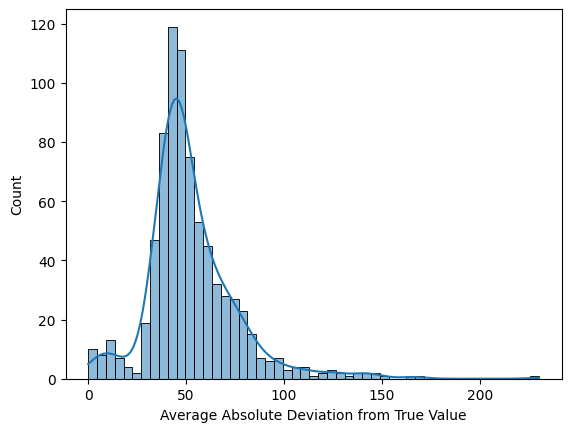

In [465]:
ax= sns.histplot(abs_gru_diff, kde=True)
ax.set(xlabel="Average Absolute Deviation from True Value")
plt.savefig("figures/abs_dev_gru")

LSTM-GRU L1-Norm values

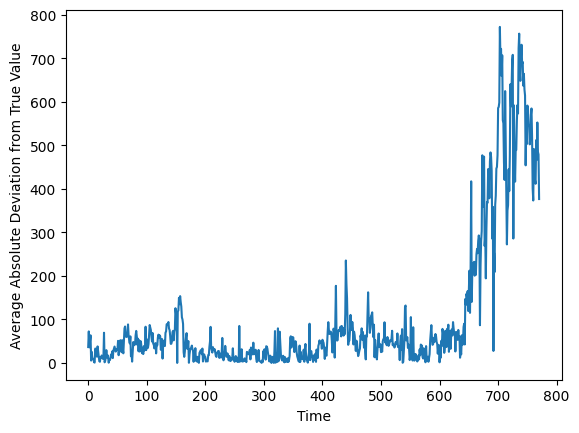

In [366]:
ax = sns.lineplot(abs_lstm_gru_diff)
ax.set(xlabel="Time", ylabel="Average Absolute Deviation from True Value")
plt.savefig("figures/abs_lstm_gru__diff_by_time")

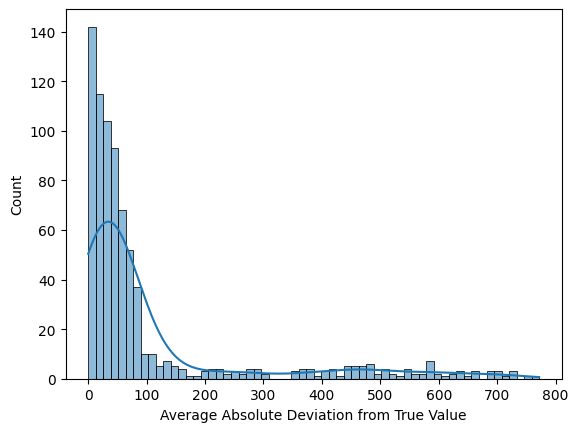

In [466]:
ax= sns.histplot(abs_lstm_gru_diff, kde=True)
ax.set(xlabel="Average Absolute Deviation from True Value")
plt.savefig("figures/abs_dev_lstm_gru")

Create full data sets for all average predictions

In [315]:
all_data = loaded_lstm_predictions[0].drop(columns = ["Predicted Next Tokyo Open", "Unnamed: 0"])

average_lstm_data = copy(all_data)

average_lstm_data.insert(6, "Predicted Next Tokyo Open", overall_predictive_average_lstm)

average_gru_data = copy(all_data)

average_gru_data.insert(6, "Predicted Next Tokyo Open", overall_predictive_average_gru)

average_lstm_gru_data = copy(all_data)

average_lstm_gru_data .insert(6, "Predicted Next Tokyo Open", overall_predictive_average_lstm_gru)

In [313]:
# function to show plot within particular ranges
def plot_dfs_in_range_(lower, upper, data):
    ax = data[0][(data[0].index > lower) & (data[0].index < upper)].plot(y="Actual Next Tokyo Open")
    for prediction in data:
        prediction[(prediction.index > lower) & (prediction.index < upper)].plot(ax=ax, y="Predicted Next Tokyo Open", linestyle = "dashed")
    
    return ax

Plots for multiple ranges and particular time frames

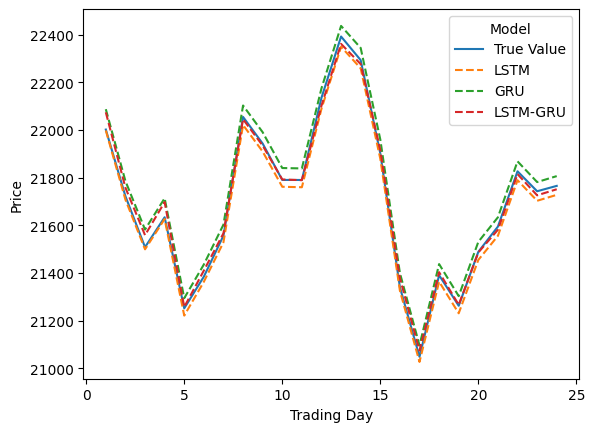

In [363]:
ax = plot_dfs_in_range_(0,25, [average_lstm_data, average_gru_data, average_lstm_gru_data])
ax.set(xlabel="Trading Day", ylabel="Price")
plt.legend(title="Model", labels = ["True Value", "LSTM", "GRU", "LSTM-GRU"])

plt.savefig("figures/first_25")

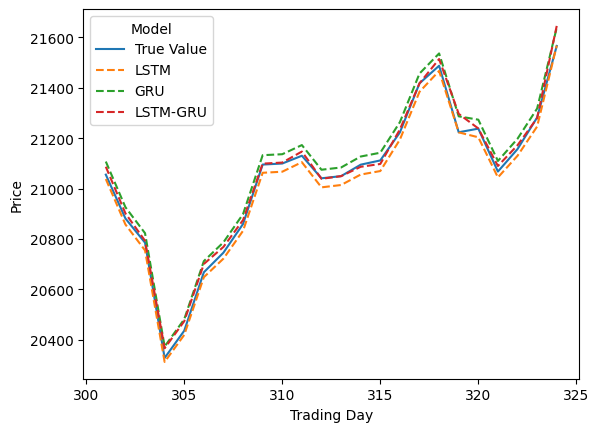

In [323]:
ax = plot_dfs_in_range_(300,325, [average_lstm_data, average_gru_data, average_lstm_gru_data])
ax.set(xlabel="Trading Day", ylabel="Price")
plt.legend(title="Model", labels = ["True Value", "LSTM", "GRU", "LSTM-GRU"])

plt.savefig("figures/middle_predict")

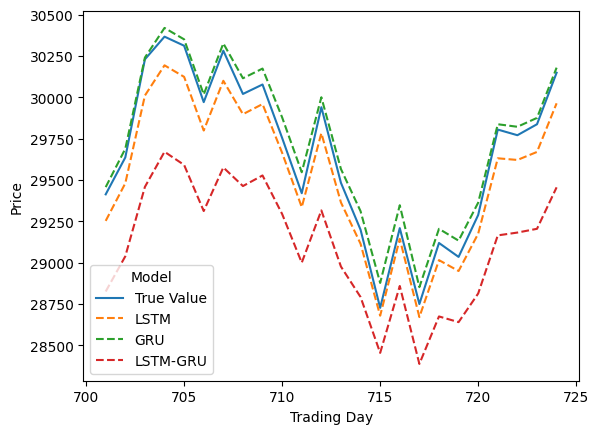

In [324]:
ax = plot_dfs_in_range_(700,725, [average_lstm_data, average_gru_data, average_lstm_gru_data])
ax.set(xlabel="Trading Day", ylabel="Price")
plt.legend(title="Model", labels = ["True Value", "LSTM", "GRU", "LSTM-GRU"])

plt.savefig("figures/end_predict")

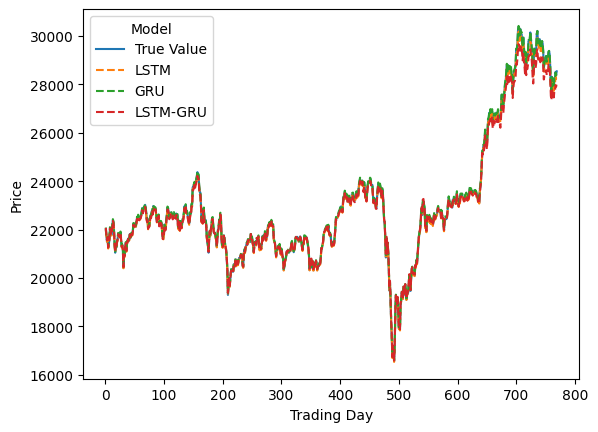

In [325]:
ax = plot_dfs_in_range_(0,770, [average_lstm_data, average_gru_data, average_lstm_gru_data])
ax.set(xlabel="Trading Day", ylabel="Price")
plt.legend(title="Model", labels = ["True Value", "LSTM", "GRU", "LSTM-GRU"])

plt.savefig("figures/all_predictions")

Covid Crash plot

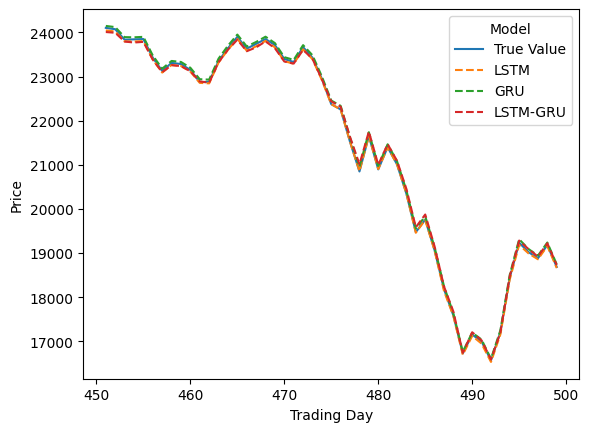

In [337]:
ax = plot_dfs_in_range_(450,500, [average_lstm_data, average_gru_data, average_lstm_gru_data])
ax.set(xlabel="Trading Day", ylabel="Price")
plt.legend(title="Model", labels = ["True Value", "LSTM", "GRU", "LSTM-GRU"])

plt.savefig("figures/covid_predict")